### Libraries

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure,binary_erosion)
from scipy.ndimage.morphology import iterate_structure

from pydub import AudioSegment
from pydub.playback import play

sampling_rate = 44100

/Users/rahuls98/anaconda3/lib/python3.7/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


***

### Original track 

##### Load and plot

In [2]:
orig_data, orig_sr = librosa.load('../Audio-files/cello-double.wav')

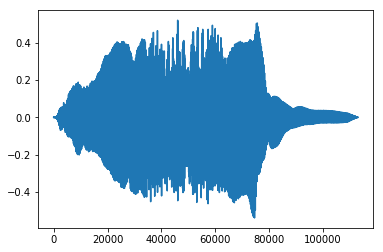

In [3]:
plt.plot(orig_data)
plt.show()

In [4]:
!play '../Audio-files/cello-double.wav'


../Audio-files/cello-double.wav:

 File Size: 452k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:05.12  

In:100%  00:00:05.12 [00:00:00.00] Out:226k  [      |      ] Hd:5.3 Clip:0    
Done.


##### Specgram

In [5]:
orig_spec, orig_freqs, orig_times = mlab.specgram(orig_data, NFFT=4096, Fs=sampling_rate, noverlap=int(4096 / 2))
orig_spec[orig_spec == 0] = 1e-6

In [6]:
print(orig_spec)

[[9.96004120e-09 9.82802173e-09 9.91266180e-09 ... 9.87777752e-09
  9.54964197e-09 3.95772262e-09]
 [5.05188660e-09 4.89486055e-09 4.96580657e-09 ... 4.98049244e-09
  5.07415432e-09 2.32327280e-09]
 [5.14225693e-13 4.01741361e-14 2.22169383e-13 ... 2.10788840e-13
  3.04493736e-12 1.78226328e-11]
 ...
 [4.32712768e-18 1.04182405e-17 6.73944044e-17 ... 2.50212444e-18
  2.69751164e-18 2.33956518e-18]
 [2.80519942e-18 3.26567826e-18 8.04443798e-19 ... 1.92651186e-18
  5.27406519e-18 8.26881150e-19]
 [4.53271515e-22 2.31460646e-18 7.55677695e-18 ... 2.31459590e-18
  9.84350595e-19 3.27354681e-21]]


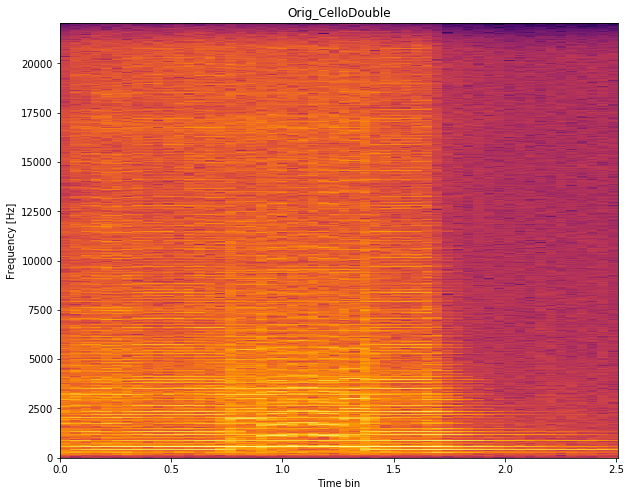

In [7]:
fig1 = plt.figure(figsize=(10, 8), facecolor='white')
extent = 0, np.amax(orig_times), orig_freqs[0], orig_freqs[-1] #data coord of bounding box

orig_Z = 10.0 * np.log10(orig_spec)
orig_Z = np.flipud(orig_Z)

plt.imshow(orig_Z, cmap='inferno', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Orig_CelloDouble')
plt.axis('auto')

ax = plt.gca() #get current axes
ax.set_xlim([0, extent[1]])
ax.set_ylim([orig_freqs[0], orig_freqs[-1]])

plt.show()

***

In [8]:
#90% cutoff threshold to remove noise
def find_ninety_C_k(spec_gram):
    spec_gram = spec_gram[spec_gram != 0] #remove 0's
    specgram_flattened = spec_gram.flatten() #returns copy of orig
    specgram_sorted = np.sort(np.log(np.abs(specgram_flattened)))
    specgram_length = len(specgram_sorted)
    
    ninety_index = int(0.9 * specgram_length)
    ninety_C_k = specgram_sorted[ninety_index]
    return ninety_C_k

In [9]:
def spectrogram_to_peaks(specgram, freqs, times):
    fp = generate_binary_structure(2,1)
    fp = iterate_structure(fp, 20)
    background_threshold = find_ninety_C_k(specgram)
    peaks = ((specgram == maximum_filter(specgram, footprint = fp) ) & (specgram > background_threshold))
    return peaks

***

##### Fingerprint

In [10]:
orig_peaks_array = spectrogram_to_peaks(orig_spec, orig_freqs, orig_times)
orig_peaks_where = np.where(orig_peaks_array)
orig_x = orig_peaks_where[0]
orig_y = orig_peaks_where[1]

In [11]:
orig_x, orig_y

(array([   0,   55,   82,  104,  123,  164,  186,  219,  246,  280,  301,
         328,  374,  410,  443,  469,  514,  554,  573,  614,  654,  656,
         697,  720,  738,  779,  818,  846,  857,  886,  901,  938,  981,
         984, 1013, 1028, 1066, 1092, 1114, 1148, 1187, 1199, 1227, 1231,
        1251, 1270, 1312, 1331, 1354, 1394, 1435, 1474, 1495, 1517, 1541,
        1555, 1579, 1596, 1616, 1641, 1681, 1717, 1728, 1763, 1804, 1820,
        1856, 1883, 1928, 1968, 2010]),
 array([48, 35, 36, 26, 35, 15, 18, 35, 12, 28, 12, 33, 28, 21, 23, 21, 28,
        23, 26, 13, 28,  8, 30, 23, 33, 34, 18, 23,  5, 21, 13, 21,  6, 31,
        12, 28, 31, 23, 18, 11, 14, 25, 14, 34, 25, 12, 33, 24, 28, 31, 31,
        13, 28, 32, 28, 14, 18, 14, 25, 34, 28, 17, 28, 30, 10, 27, 16, 14,
        34, 33, 32]))

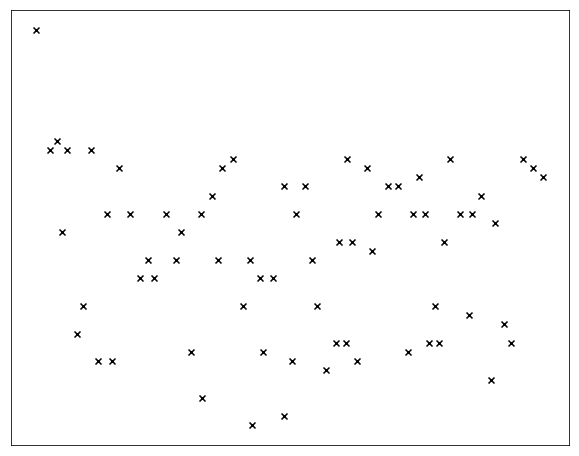

In [16]:
fig3 = plt.figure(figsize=(10, 8), facecolor='white')
plt.scatter(orig_x, orig_y, marker='x',color='black')
plt.xticks([])
plt.yticks([])
plt.show()

***

### Create a duplicate, increase speed and perform pitch shift

- Shift the pitch up by half an octave (speed will increase proportionally)
- Keep the same samples but tell the computer they ought to be played at the new, higher sample rate.
- Convert it to a common sample rate (44.1k - standard audio CD) to make sure it works in regular audio players.
- Play pitch changed sound
- Export/Save pitch changed sound

In [17]:
sound = AudioSegment.from_file('../Audio-files/cello-double.wav', format="wav")
octaves = 0.5
new_sample_rate = int(sound.frame_rate * (2.0 ** octaves))
hipitch_sound = sound._spawn(sound.raw_data, overrides={'frame_rate': new_sample_rate})
hipitch_sound = hipitch_sound.set_frame_rate(44100)
hipitch_sound.export("cello-double-out.wav", format="wav")

<_io.BufferedRandom name='cello-double-out.wav'>

In [18]:
!play 'cello-double-out.wav'


cello-double-out.wav:

 File Size: 320k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:03.62  

In:100%  00:00:03.62 [00:00:00.00] Out:160k  [      |      ] Hd:5.3 Clip:0    
Done.


##### Load and plot

In [19]:
dup1_data, dup1_sr = librosa.load('cello-double-out.wav')

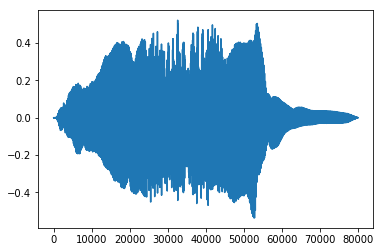

In [20]:
plt.plot(dup1_data)
plt.show()

##### Specgram

In [21]:
dup1_spec, dup1_freqs, dup1_times = mlab.specgram(dup1_data, NFFT=4096, Fs=sampling_rate, noverlap=int(4096 / 2))
dup1_spec[dup1_spec == 0] = 1e-6

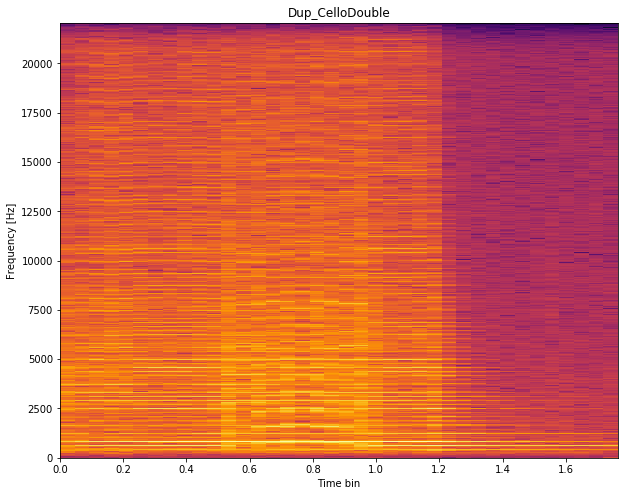

In [22]:
fig4 = plt.figure(figsize=(10, 8), facecolor='white')
extent = 0, np.amax(dup1_times), dup1_freqs[0], dup1_freqs[-1] #data coord of bounding box

dup1_Z = 10.0 * np.log10(dup1_spec)
dup1_Z = np.flipud(dup1_Z)

plt.imshow(dup1_Z, cmap='inferno', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Dup_CelloDouble')
plt.axis('auto')

ax = plt.gca() #get current axes
ax.set_xlim([0, extent[1]])
ax.set_ylim([dup1_freqs[0], dup1_freqs[-1]])

plt.show()

##### Fingerprint

In [23]:
dup1_peaks_array = spectrogram_to_peaks(dup1_spec, dup1_freqs, dup1_times)
dup1_peaks_where = np.where(dup1_peaks_array)
dup1_x = dup1_peaks_where[0]
dup1_y = dup1_peaks_where[1]

In [24]:
dup1_x, dup1_y

(array([   0,   77,  116,  147,  174,  232,  263,  310,  330,  347,  394,
         425,  464,  528,  579,  626,  663,  705,  726,  783,  811,  868,
         887,  927,  986, 1019, 1044, 1102, 1122, 1158, 1197, 1211, 1252,
        1274, 1334, 1391, 1432, 1453, 1508, 1542, 1575, 1623, 1641, 1660,
        1678, 1695, 1736, 1768, 1795, 1856, 1881, 1914, 1972]),
 array([ 4, 25, 25, 18, 24, 10, 12, 25, 20,  9, 12, 10, 23, 19, 15, 16, 18,
        16, 19, 16, 18, 10, 14, 21, 22, 16, 23, 23, 20, 10, 16,  3, 15,  9,
        22, 21,  8, 19, 22,  2, 12,  8, 12, 19, 10, 18, 10, 18,  9, 23, 16,
        22, 22]))

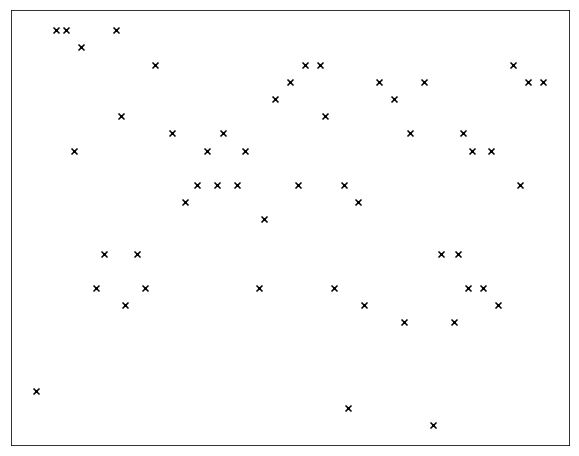

In [49]:
fig5 = plt.figure(figsize=(10, 8), facecolor='white')
plt.scatter(dup1_x, dup1_y, marker='x',color='black')
plt.xticks([])
plt.yticks([])
plt.show()

***

### Recorded through mic

In [124]:
import pyaudio
import wave
from array import array

FORMAT=pyaudio.paInt16
CHANNELS=2
RATE=44100
CHUNK=1024
RECORD_SECONDS=6
FILE_NAME="recording.wav"

audio=pyaudio.PyAudio() #instantiate the pyaudio

#recording prerequisites
stream=audio.open(format=FORMAT,channels=CHANNELS, 
                  rate=RATE,
                  input=True,
                  frames_per_buffer=CHUNK)

#starting recording
frames=[]

for i in range(0,int(RATE/CHUNK*RECORD_SECONDS)):
    data=stream.read(CHUNK)
    data_chunk=array('h',data)
    vol=max(data_chunk)
    #if(vol>=500):
    #    print("something said")
    #    frames.append(data)
    #else:
    #    print("nothing")
    #print("\n")
    frames.append(data)


#end of recording
stream.stop_stream()
stream.close()
audio.terminate()
#writing to file
wavfile=wave.open(FILE_NAME,'wb')
wavfile.setnchannels(CHANNELS)
wavfile.setsampwidth(audio.get_sample_size(FORMAT))
wavfile.setframerate(RATE)
wavfile.writeframes(b''.join(frames))#append frames recorded to file
wavfile.close()

##### Load and plot

In [26]:
rec_data, rec_sr = librosa.load('recording.wav')

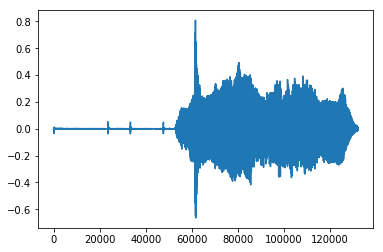

In [27]:
plt.plot(rec_data)
plt.show()

In [28]:
!play 'recording.wav'


recording.wav:

 File Size: 1.06M     Bit Rate: 1.41M
  Encoding: Signed PCM    
  Channels: 2 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:05.99  

In:100%  00:00:05.99 [00:00:00.00] Out:264k  [      |      ]        Clip:0    
Done.


##### Specgram

In [29]:
rec_spec, rec_freqs, rec_times = mlab.specgram(rec_data, NFFT=4096, Fs=sampling_rate, noverlap=int(4096 / 2))
rec_spec[rec_spec == 0] = 1e-6

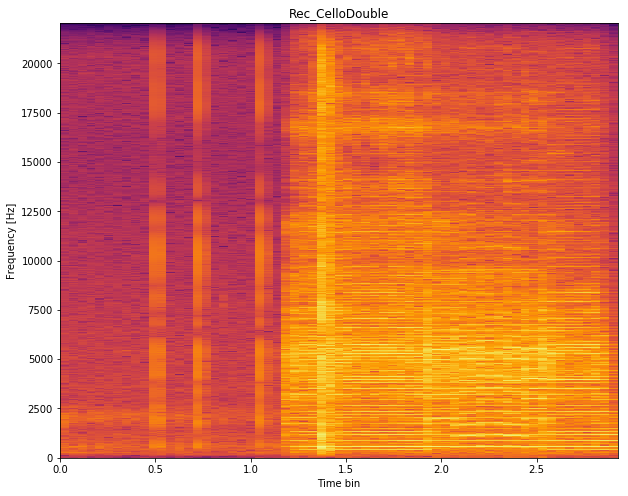

In [31]:
fig6 = plt.figure(figsize=(10, 8), facecolor='white')
extent = 0, np.amax(rec_times), rec_freqs[0], rec_freqs[-1] #data coord of bounding box

rec_Z = 10.0 * np.log10(rec_spec)
rec_Z = np.flipud(rec_Z)

plt.imshow(rec_Z, cmap='inferno', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Rec_CelloDouble')
plt.axis('auto')

ax = plt.gca() #get current axes
ax.set_xlim([0, extent[1]])
ax.set_ylim([rec_freqs[0], rec_freqs[-1]])

plt.show()

##### Fingerprint

In [32]:
rec_peaks_array = spectrogram_to_peaks(rec_spec, rec_freqs, rec_times)
rec_peaks_where = np.where(rec_peaks_array)
rec_x = rec_peaks_where[0]
rec_y = rec_peaks_where[1]

In [33]:
rec_x, rec_y

(array([  24,   55,   82,   82,  104,  109,  123,  164,  164,  186,  219,
         219,  234,  246,  301,  328,  368,  374,  410,  437,  469,  514,
         532,  553,  575,  614,  656,  696,  710,  721,  734,  738,  778,
         779,  819,  856,  885,  902,  981,  990, 1003, 1066, 1075, 1096,
        1114, 1146, 1187, 1229, 1270, 1295, 1310, 1356, 1401, 1406, 1435,
        1460, 1511, 1555, 1580, 1596, 1617, 1641, 1651, 1690, 1726, 1728,
        1749, 1772, 1775, 1807, 1820, 1855, 1899, 1928, 1974]),
 array([ 1, 39, 39, 61, 51, 29, 39, 40, 61, 43, 37, 60, 53, 38, 37, 58, 32,
        53, 35, 40, 46, 53, 40, 48, 38, 38, 33, 40, 29, 49, 29, 58, 38, 59,
        40, 29, 47, 29, 31, 51, 29, 56, 29, 29, 43, 39, 39, 37, 38, 29, 39,
        29, 53, 29, 56, 29, 29, 39, 29, 39, 29, 58, 29, 29, 29, 53, 30, 29,
        53, 29, 52, 29, 29, 29, 29]))

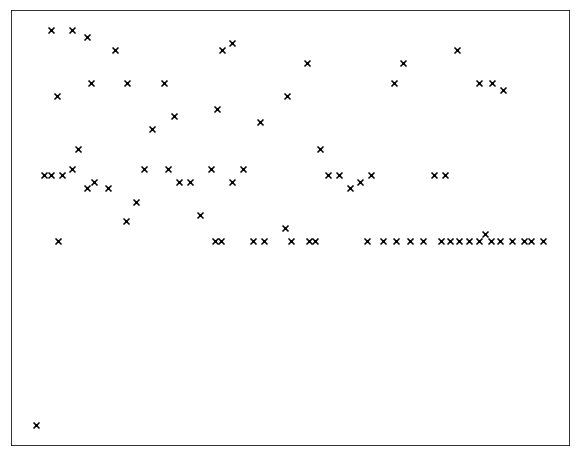

In [50]:
fig7 = plt.figure(figsize=(10, 8), facecolor='white')
plt.scatter(rec_x, rec_y, marker='x',color='black')
plt.xticks([])
plt.yticks([])
plt.show()

***

### Proper copy

##### Load and plot

In [35]:
proper_data, proper_sr = librosa.load('cello-double.wav')

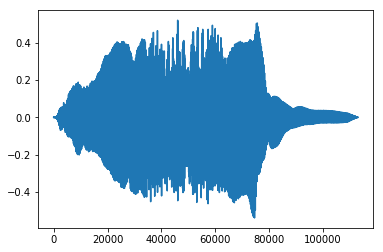

In [36]:
plt.plot(proper_data)
plt.show()

In [37]:
!play 'cello-double.wav'


cello-double.wav:

 File Size: 452k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:05.12  

In:100%  00:00:05.12 [00:00:00.00] Out:226k  [      |      ] Hd:5.3 Clip:0    
Done.


##### Specgram

In [38]:
proper_spec, proper_freqs, proper_times = mlab.specgram(proper_data, NFFT=4096, Fs=sampling_rate, noverlap=int(4096 / 2))
proper_spec[proper_spec == 0] = 1e-6

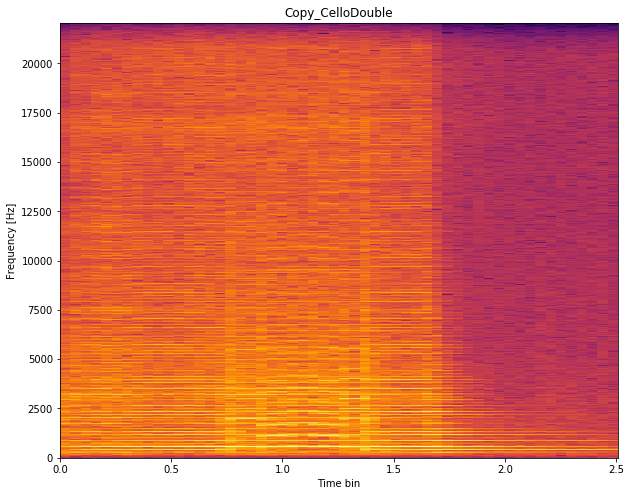

In [39]:
fig6 = plt.figure(figsize=(10, 8), facecolor='white')
extent = 0, np.amax(proper_times), proper_freqs[0], proper_freqs[-1] #data coord of bounding box

proper_Z = 10.0 * np.log10(proper_spec)
proper_Z = np.flipud(proper_Z)

plt.imshow(proper_Z, cmap='inferno', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Copy_CelloDouble')
plt.axis('auto')

ax = plt.gca() #get current axes
ax.set_xlim([0, extent[1]])
ax.set_ylim([proper_freqs[0], proper_freqs[-1]])

plt.show()

##### Fingerprint

In [40]:
proper_peaks_array = spectrogram_to_peaks(proper_spec, proper_freqs, proper_times)
proper_peaks_where = np.where(proper_peaks_array)
proper_x = proper_peaks_where[0]
proper_y = proper_peaks_where[1]

In [41]:
proper_x, proper_y

(array([   0,   55,   82,  104,  123,  164,  186,  219,  246,  280,  301,
         328,  374,  410,  443,  469,  514,  554,  573,  614,  654,  656,
         697,  720,  738,  779,  818,  846,  857,  886,  901,  938,  981,
         984, 1013, 1028, 1066, 1092, 1114, 1148, 1187, 1199, 1227, 1231,
        1251, 1270, 1312, 1331, 1354, 1394, 1435, 1474, 1495, 1517, 1541,
        1555, 1579, 1596, 1616, 1641, 1681, 1717, 1728, 1763, 1804, 1820,
        1856, 1883, 1928, 1968, 2010]),
 array([48, 35, 36, 26, 35, 15, 18, 35, 12, 28, 12, 33, 28, 21, 23, 21, 28,
        23, 26, 13, 28,  8, 30, 23, 33, 34, 18, 23,  5, 21, 13, 21,  6, 31,
        12, 28, 31, 23, 18, 11, 14, 25, 14, 34, 25, 12, 33, 24, 28, 31, 31,
        13, 28, 32, 28, 14, 18, 14, 25, 34, 28, 17, 28, 30, 10, 27, 16, 14,
        34, 33, 32]))

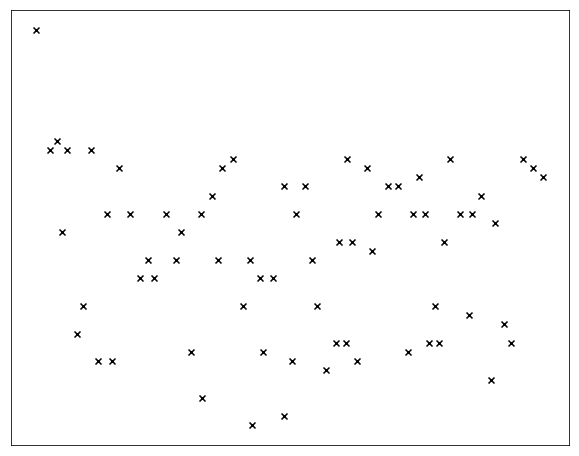

In [51]:
fig7 = plt.figure(figsize=(10, 8), facecolor='white')
plt.scatter(proper_x, proper_y, marker='x',color='black')
plt.xticks([])
plt.yticks([])
plt.show()

***

### Check status

In [43]:
def zipped(x, y):
    return list(zip(x,y))

In [44]:
orig_fp = zipped(orig_x, orig_y)
dup1_fp = zipped(dup1_x, dup1_y)
rec_fp = zipped(rec_x, rec_y)
proper_fp = zipped(proper_x, proper_y)

In [45]:
orig_len = len(orig_fp)

def status(fp):
    if len(fp) < orig_len:
        return("Trimmed track or Increased Tempo")
    elif len(fp)==orig_len:
        for i in range(0, len(fp)):
            if fp[i]==orig_fp[i]:
                continue 
        return("Authentic distribution")
    else:
        return("Recorded or Different Track")

In [46]:
print("2 : ",status(dup1_fp))
print("3 : ",status(rec_fp))
print("4 : ",status(proper_fp))

2 :  Trimmed track or Increased Tempo
3 :  Recorded or Different Track
4 :  Authentic distribution


Text(0.5, 1.0, 'Authentic')

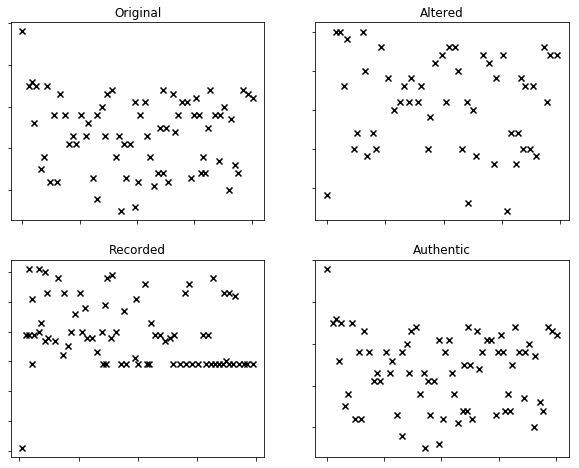

In [48]:
f = plt.figure(figsize=(10,8))

ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.scatter(orig_x, orig_y, marker='x',color='black')
ax2.scatter(dup1_x, dup1_y, marker='x',color='black')
ax3.scatter(rec_x, rec_y, marker='x',color='black')
ax4.scatter(proper_x, proper_y, marker='x',color='black')

ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_xticklabels([])

ax1.set_title('Original')
ax2.set_title('Altered')
ax3.set_title('Recorded')
ax4.set_title('Authentic')